# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

### Homework 1 is due February 6th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [13]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
#%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns
def easy_plot_details(axis, title, xlabel, ylabel, subplot = False):
    """
    This function allows for simple plot axis labeling and formating.
    """
    if subplot == True:
        axis.title.set_text(title[0])
        axis.title.set_size(title[1])
        axis.set_xlabel( xlabel[0])
        axis.set_ylabel( ylabel[0])
    else:
        axis.tick_params( labelsize=12)
        axis.set_title(  title[0], fontsize = title[1])
        axis.set_ylabel( ylabel[0], fontsize = ylabel[1])
        axis.set_xlabel( xlabel[0], fontsize = xlabel[1])
    #axis.legend(loc = 'best', fontsize=8);


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [3]:
#your code here
cal_train = pd.read_csv("data/calendar_train.csv", parse_dates = True)
cal_test = pd.read_csv("data/calendar_test.csv", parse_dates = True)
cal_train.head

<bound method NDFrame.head of         listing_id      date available  price
0         20872145   9/21/18         f    NaN
1         20872145   9/19/18         f    NaN
2         20872145   9/18/18         f    NaN
3         20872145   9/17/18         f    NaN
4         20872145   9/16/18         f    NaN
...            ...       ...       ...    ...
733998     4759640  12/21/17         f    NaN
733999     4759640  12/20/17         f    NaN
734000     4759640  12/19/17         f    NaN
734001     4759640  12/18/17         f    NaN
734002     4759640  12/15/17         f    NaN

[734003 rows x 4 columns]>

### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

In [4]:
cal_train['date'] = pd.to_datetime(cal_train['date'])
cal_test['date'] = pd.to_datetime(cal_test['date'])

days_of_wk = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = [
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

cal_train['month'] = cal_train['date'].apply(lambda x : months[x.month-1])
cal_train['day_of_wk'] = cal_train['date'].apply(lambda x : days_of_wk[x.dayofweek]) 

cal_test['month'] = cal_test['date'].apply(lambda x : months[x.month-1])
cal_test['day_of_wk'] = cal_test['date'].apply(lambda x : days_of_wk[x.dayofweek]) 

In [5]:
#np.unique(cal_train['month'])

In [6]:
#your code here
cal_train_2 = cal_train.copy()
cal_train_available = cal_train_2[cal_train_2['available'] != 'f']
cal_test_available = cal_test[cal_test['available'] != 'f']

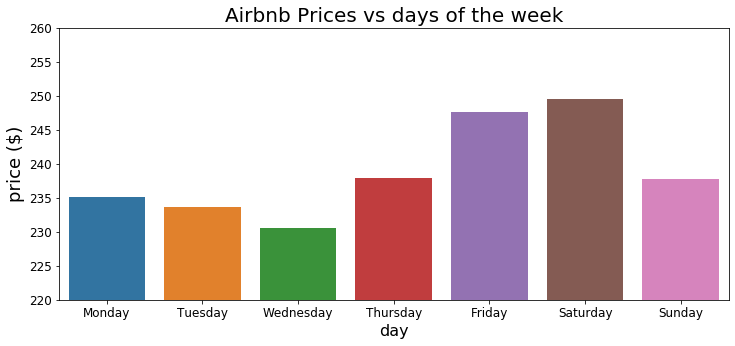

In [7]:
#mean
price_mns_days_of_wk = []
#median
price_med_days_of_wk = []
for day in days_of_wk:
    tmp = cal_train_available[cal_train_available['day_of_wk'] == day]
    price_mns_days_of_wk.append(round(np.mean(tmp['price']),2))
    price_med_days_of_wk.append(round(np.median(tmp['price']),2))
    
days_of_wk_df = pd.DataFrame(np.ones(7))
days_of_wk_df[0] = days_of_wk
days_of_wk_df[1] = price_mns_days_of_wk
days_of_wk_df.columns = ["day","price"]

ax =  fig, ax = plt.subplots(1, 1, figsize=(12, 5))

sns.barplot(x = "day", y = "price", data = days_of_wk_df) #, showfliers=False
ax.set(ylim=(220, 260))
easy_plot_details(ax, ["Airbnb Prices vs days of the week",20], ["day",16], ["price ($)",18], subplot = False)


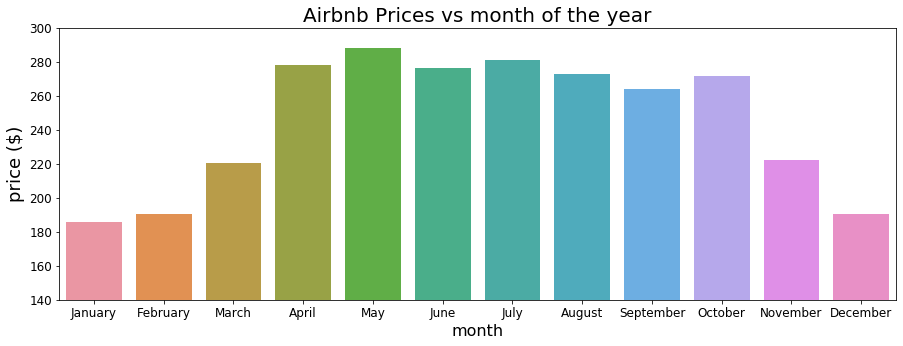

In [8]:
price_mns_months = []
for month in months:
    tmp = cal_train_available[cal_train_available['month'] == month]
    price_mns_months.append(round(np.mean(tmp['price']),2))
    
month_df = pd.DataFrame(np.ones(12))
month_df[0] = months
month_df[1] = price_mns_months
month_df.columns = ["month","price"]

ax =  fig, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.barplot(x = "month", y = "price", data = month_df) #, showfliers=False
ax.set(ylim=(140, 300))
easy_plot_details(ax, ["Airbnb Prices vs month of the year",20], ["month",16], ["price ($)",18], subplot = False)


**Analysis**

$\bullet$ We can see that for the days of the week, Friday and Saturday are most expensive indicating that prices rise on the weekends.

$\bullet$ We can see that for the months of the year, the winter (January and February) are the least expensive times while the summer (April through August) is the most expensive time.

$\bullet$ This makes sense because people are more likely to travel durring summer (vacation time) and the weekend (which can be viewed as a weekly mini-vacation).

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [9]:
#your code here
df = cal_train_available.sample(n=5000, random_state=1)
num_dates = cal_train_available['date'] - min(cal_train_available['date'] )
num_dates = num_dates.dt.days

num_dates_test = cal_test_available['date'] - min(cal_test_available['date'] )
num_dates_test = num_dates_test.dt.days

### 1. Polynomials

In [10]:
#your code here
#cal_train_available['date'] = pd.to_datetime(cal_train_available['date']) 
X=np.array(num_dates).reshape(-1,1)
y=np.array(cal_train_available['price'])

X_train=np.array(num_dates).reshape(-1,1)

X_test=np.array(num_dates_test).reshape(-1,1)
y_test=np.array(cal_train_available['price'])

display(cal_train_available.head)

<bound method NDFrame.head of         listing_id       date available  price     month  day_of_wk
123       20872145 2018-04-02         t   62.0     April     Monday
124       20872145 2018-04-01         t   59.0     April     Sunday
125       20872145 2018-03-31         t   75.0     March   Saturday
126       20872145 2018-03-30         t   71.0     March     Friday
127       20872145 2018-03-28         t   51.0     March  Wednesday
...            ...        ...       ...    ...       ...        ...
733756    15589328 2018-06-26         t  149.0      June    Tuesday
733757    15589328 2018-06-25         t  149.0      June     Monday
733758    15589328 2018-06-23         t  149.0      June   Saturday
733759    15589328 2018-06-22         t  149.0      June     Friday
733766    15589328 2017-11-01         t  101.0  November  Wednesday

[309288 rows x 6 columns]>

In [11]:

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


poly2, poly3, poly5, poly8 =  PolynomialFeatures(degree = 2), PolynomialFeatures(degree = 3),  PolynomialFeatures(degree = 5),  PolynomialFeatures(degree = 8)
X_lst = []
X_lst_test = []
pol_lst = [poly2, poly3, poly5, poly8]
for i, pol in enumerate(pol_lst):
    
    last_col = X
    last_col_test = X_test
    X = last_col
    X_test = last_col_test
    X_poly = pol.fit_transform(X)
    pol.fit(X_poly, y)
    X_lst.append(X_poly)
    
    X_poly = pol.fit_transform(X_test)
    pol.fit(X_poly, y)
    X_lst_test.append(X_poly[:,-1].reshape(-1,1))
    

for i, pol in enumerate(pol_lst):
    X_lst.append(pol.fit_transform(X))
    X_lst_test.append(pol.fit_transform(X_test))

model = LinearRegression()

#try stats model ols, add constant

model.fit(X_lst[0], y) 
#train_predicted = model.predict(poly2.fit_transform(X))

predicted_vals=[]
pred_vals_test=[]
for i, pol in enumerate(pol_lst):
    model.fit(X_lst[i], y)
    predicted_vals.append(model.predict(pol.fit_transform(X)))
    pred_vals_test.append(model.predict(pol.fit_transform(X_test)))
    



In [12]:
display(num_dates)

123       178
124       177
125       176
126       175
127       173
         ... 
733756    263
733757    262
733758    260
733759    259
733766     26
Name: date, Length: 309288, dtype: int64

In [13]:
daily_avgs = []
daily_avgs_test = []
for i in range(max(num_dates) + 1):
    daily_avg = np.mean(cal_train_available['price'][num_dates == i])
    daily_avgs.append(daily_avg)
    daily_avg_test = np.mean(cal_test_available['price'][num_dates_test == i])
    daily_avgs_test.append(daily_avg_test)

In [14]:
num_dates

123       178
124       177
125       176
126       175
127       173
         ... 
733756    263
733757    262
733758    260
733759    259
733766     26
Name: date, Length: 309288, dtype: int64

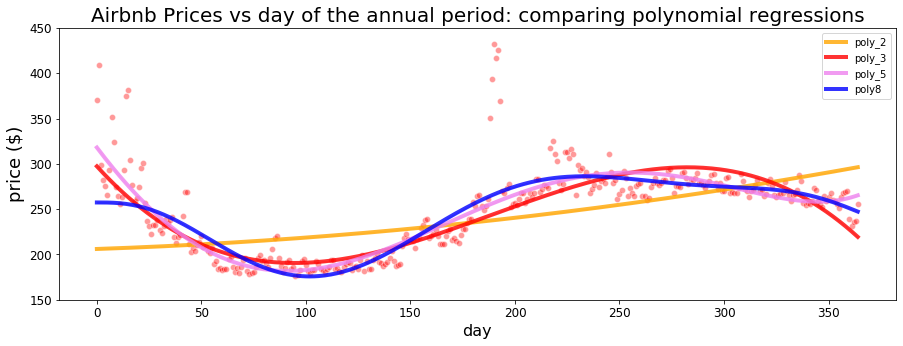

In [15]:
n = 100
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

colors = ["orange", "red", "violet","blue"]
names = ["poly_2", "poly_3", "poly_5", "poly8"]

sns.scatterplot(x=list(range(max(num_dates)+1)), y=daily_avgs, color = 'red', alpha = 0.4) 
for i, pred_vals in enumerate(predicted_vals):
    sns.lineplot(x=num_dates, y=pred_vals, color = colors[i], label = names[i], alpha = 0.8, sizes = [100],  linewidth=4)
ax.set(ylim=(150, 450))
easy_plot_details(ax, ["Airbnb Prices vs day of the annual period: comparing polynomial regressions",20], ["day",16], ["price ($)",18], subplot = False)


In [16]:
r2_scores = []
r2_scores_test = []
for i, val in enumerate(predicted_vals):
    r2_scores.append(r2_score(cal_train_available["price"],val))
    #test val
    test_val = pred_vals_test[i]
    r2_scores_test.append(r2_score(cal_test_available["price"],test_val))
r2_df = pd.DataFrame([[2,3,5,8],r2_scores,r2_scores_test]).T
r2_df.columns = ["degree", "train_r2_score", "test_r2_score"]
display(r2_df)

#I'll stop here. The next step is to make a work pipeline above, that cleanly deals with the test data set in the same way
#as the training data set.

,degree,train_r2_score,test_r2_score
0,2.0,0.018489,0.019180
1,3.0,0.038933,0.038752
2,5.0,0.042100,0.041738
3,8.0,0.041389,0.040886


_your answer here_


### 2. Degree 8 oddity

## THIS NEEDS WORK, also did I correctly specify a "simple polynomial model" or do I just need one thing?

The degree 8 polynomial performs terribly near 0 as it systematically underestimates those data points, whereas the degree 5 and degree 3 polynomails perform better at cutting through the data points. At the other end of the graph however, the degree 8 polynomial does well while the degree 3 polynomial systematically underestimates the relationship.

Polynomial models in general perform poorly at the boundaries of the data. They can be much improved by adding knots and transitioning to splines or other more sophisticated methods of introducing non-linearity into the model.

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

Fit a Smoothing spline model in pygam with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [17]:

#gam=LinearGAM(terms='auto', max_iter=100, tol=0.0001, fit_intercept=True, verbose=False )
#gam.fit(X,y)
gam = LinearGAM(s(0))#, lam = 0.00001).fit(X, y)
lam = np.logspace(-9, 10)
lams = [lam]*3

gam.gridsearch(X, y, lam=lam)
gam.summary()

#

100% (50 of 50) |########################| Elapsed Time: 0:01:20 Time:  0:01:20


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.6535
Link Function:                     IdentityLink Log Likelihood:                              -3510882.9889
Number of Samples:                       309288 AIC:                                          7021807.2847
                                                AICc:                                         7021807.2876
                                                GCV:                                            33950.5947
                                                Scale:                                          33946.7114
                                                Pseudo R-Squared:                                    0.045
Feature Function                  Lam

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


In [18]:
gam_test_pred_vals = gam.predict(X_test)
gam_train_pred_vals = gam.predict(X)
train_r2_score =  r2_score(cal_test_available["price"],gam_test_pred_vals)
test_r2_score  =  r2_score(cal_train_available["price"],gam_train_pred_vals)
print("cross-val train R^2 score:" + str(round(train_r2_score,6)))
print("cross-val test  R^2 score: " + str(round(test_r2_score,6)))

#0.044781027804570384

cross-val train R^2 score:0.044797
cross-val test  R^2 score: 0.044964


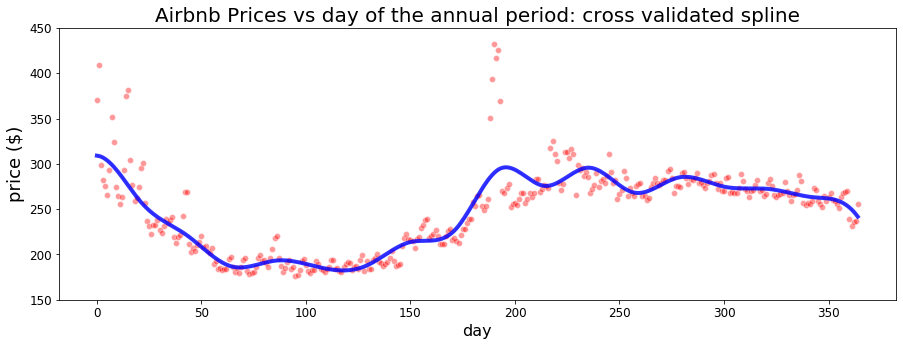

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.scatterplot(x=list(range(max(num_dates)+1)), y=daily_avgs, color = 'red', alpha = 0.4) 
sns.lineplot(x=num_dates_test, y=gam_test_pred_vals, color = "blue", alpha = 0.8,  linewidth=4)
ax.set(ylim=(150, 450))
easy_plot_details(ax, ["Airbnb Prices vs day of the annual period: cross validated spline",20], ["day",16], ["price ($)",18], subplot = False)


Below I plot various smoothing parameters, with the cross-validated spline line plotted in white. As you can see it closely tracks the line with barely any smoothing at all.

1e-05
1000


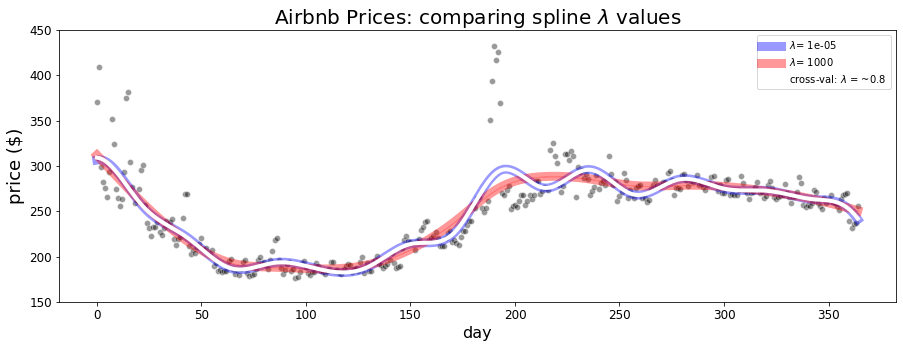

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set(ylim=(150, 450))
sns.scatterplot(x=list(range(max(num_dates)+1)), y=daily_avgs, color = 'black', alpha = 0.4)
cols = ["blue", "red"]
for j, i in enumerate([10**(-5),1000 ]): #[np.exp(-10 + 2*i) for i in range(11) ]:
    print(i)
    gam = LinearGAM(s(0), lam = i).fit(X,y)
    gam_test_pred_vals_ = gam.predict(X_test)
    sns.lineplot(x=num_dates_test, y=gam_test_pred_vals_, color = cols[j], alpha = 0.4, dashes=(2, 2),  linewidth=9, label = "$\lambda$= " + str(i))
    
sns.lineplot(x=num_dates_test, y=gam_test_pred_vals, color = "white", alpha = 1,  linewidth=4, label = "cross-val: $\lambda$ = ~0.8")
easy_plot_details(ax, ["Airbnb Prices: comparing spline $\lambda$ values",20], ["day",16], ["price ($)",18], subplot = False)


### 4. Effects of parameters
_your answer here_

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


In [21]:
#your code here
def is_weekend(df_tmp):
    df_ = df_tmp.copy()
    sat = df_["day_of_wk"] == "Saturday" 
    sun = df_["day_of_wk"] == "Sunday" 
    wknd = np.logical_or(sat,sun)
    #df_ = ["weekend"] = weekend
    return(wknd)

train_wknd = is_weekend(cal_train_available)
test_wknd  = is_weekend(cal_test_available)

X_new = np.append(X, np.array(train_wknd).reshape(-1,1),1)
X_new_test = np.append(X_test, np.array(test_wknd).reshape(-1,1),1)

In [22]:
gam=LinearGAM(terms='auto', max_iter=100, tol=0.0001, fit_intercept=True, verbose=False )
lam = np.logspace(-9, 10)
lams = [lam]*3

gam.gridsearch(X_new, y, lam=lam)
gam.summary()

100% (50 of 50) |########################| Elapsed Time: 0:03:01 Time:  0:03:01


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     20.6533
Link Function:                     IdentityLink Log Likelihood:                              -3510793.9122
Number of Samples:                       309288 AIC:                                          7021631.1311
                                                AICc:                                         7021631.1343
                                                GCV:                                            33941.0245
                                                Scale:                                          33936.9449
                                                Pseudo R-Squared:                                   0.0452
Feature Function                  Lam

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


In [23]:
gam_test_pred_vals_wknd = gam.predict(X_new_test)
r2_score(cal_test_available["price"],gam_test_pred_vals_wknd)

0.04501464734470184

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


DatetimeIndex(['2017-10-06', '2017-10-07', '2017-10-08', '2017-10-09',
               '2017-10-10', '2017-10-11', '2017-10-12', '2017-10-13',
               '2017-10-14', '2017-10-15',
               ...
               '2018-09-26', '2018-09-27', '2018-09-28', '2018-09-29',
               '2018-09-30', '2018-10-01', '2018-10-02', '2018-10-03',
               '2018-10-04', '2018-10-05'],
              dtype='datetime64[ns]', length=365, freq=None)

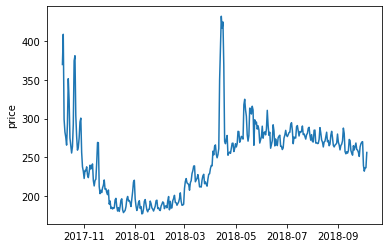

In [24]:
#your code here
dtidx = pd.DatetimeIndex(np.unique(cal_train_available['date']))
dff = pd.DataFrame(daily_avgs, dtidx )
dff.columns =["price"]

dff.head(10)
dff["date"]=dtidx
#cal_train_available2.head(10)
sns.lineplot(x = dtidx, y = "price",data = dff)
dtidx

In [25]:
dff.sort_values(by=['price'], ascending = False).head(10)

,price,date
2018-04-14,432.680761,2018-04-14
2018-04-16,425.289528,2018-04-16
2018-04-15,417.170404,2018-04-15
2017-10-07,409.298701,2017-10-07
2018-04-13,393.609047,2018-04-13
2017-10-21,381.526515,2017-10-21
2017-10-20,374.955932,2017-10-20
2017-10-06,370.173410,2017-10-06
2018-04-17,369.371060,2018-04-17
2017-10-13,351.800725,2017-10-13


$\bullet$ Outliers

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [5]:
#your code here
train_listing = pd.read_csv("data/listings_train.csv")
test_listing  = pd.read_csv( "data/listings_test.csv")

_your answer here_

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

The problem with this code is that it doesn't actually include room type.

In [30]:
#your code here
from sklearn.linear_model import LinearRegression

train_listing.head(3)
quant_cols = ["host_total_listings_count", 
"bathrooms","bedrooms", "beds",  "security_deposit", #"price",
"cleaning_fee", "availability_365", "number_of_reviews","latitude", "longitude"] # "room_type", 

XX = train_listing[quant_cols]
XX_test = test_listing[quant_cols]

pol = PolynomialFeatures(degree = 2)

y = train_listing['price']

X_poly = pol.fit_transform(XX)
pol.fit(X_poly, y)

X_poly = pd.DataFrame(X_poly)
X_poly['room_type'] = train_listing['room_type']
X_poly = np.array(X_poly)

model = LinearRegression()

#train_predicted = model.predict(poly2.fit_transform(X))

model.fit(X_poly, y)
predicted_vals = model.predict(pol.fit_transform(XX))
pred_vals_test = model.predict(pol.fit_transform(XX_test))

predicted_vals
    
train_score = r2_score(train_listing["price"], predicted_vals)

test_score = r2_score(test_listing["price"], pred_vals_test)

print("train_score: "+ str(train_score))

print("test_score: "+ str(test_score))

#X_lst_test.append(X_poly[:,-1].reshape(-1,1))

ValueError: could not convert string to float: 'Private room'

### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


_your answer here_


In [ ]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
#your code here

In [ ]:
#your code here

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

_your answer here_